In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline

from MicroseismicDETR.utils import *
from MicroseismicDETR.dataset import *
from MicroseismicDETR.model import *

# Check available device
device = avail_device()
print(f'Device: {device}')

GPU is working hard for you!
Device: cuda


### Configurations

In [2]:
# Define data parameters
nx = 141   # number of space samples for each data
nt = 101   # number of time samples for each data
nsr = 0.1/3.0   # noise level (Gaussian noise added to clean data)

# Load the trained network
set_seed(10)
network = DETRnet(num_classes=1)
network.load_state_dict(torch.load('../network/Example_Trained_Network.pt'))
network = network.to(device)

In [3]:
def test_one_data(network, input_data):
    """
    Perform testing/prediction over one data input.
    """
    
    network.eval()
    
    input_data = (input_data - input_data.mean()) / input_data.std()
    input_data = input_data.unsqueeze(dim=1)
    outputs = network(input_data)
    
    prob = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    
    keep = prob.max(-1).values > 0.7
    loc  = outputs['pred_locations'][0, keep].view(1, -1).cpu().detach().numpy()

    return prob, loc

In [4]:
# Detection-related Function(s)

def pred_event_number(probability):
    """
    Calculate the predicted number of event(s) within the input data segment.
    """
    
    keep = probability.max(-1).values > 0.7
    return (torch.count_nonzero(keep)).cpu().detach().numpy()

In [5]:
# Location-related Function(s)

def denorm_pred_loc(pred_location):
	"""
	De-normalize predicted locations.
	Note: Values are specific to this case.
	"""
	
	# Source Area: [2.1, 3.5] in x-direction & [1.7, 2.5] in z-direction
	x0 = 2.1
	z0 = 1.7
	w = 1.4
	h = 0.8
	denorm_loc = np.zeros_like(pred_location)
	denorm_loc[:, 0] = pred_location[:, 0] * w + x0
	denorm_loc[:, 1] = pred_location[:, 1] * h + z0

	return denorm_loc


def calculate_loc_error(true_location, pred_location):
    """
    Calculate the difference (L2 norm) between true and predicted locations.
    """
    
    return (np.linalg.norm(true_location - pred_location, 2, axis=1)).reshape(-1,1)


def str_format(source_location):
    """
    The string format of source locations for display purpose.
    """
    
    return np.array2string(source_location * 1000., precision=1)  # unit: km --> m

### Case #1: One-event Input Data (E1)

In [6]:
# Read one-event data
ndata_E1 = 1071
test_data_E1 = read_data("../data/testing_data_E1.bin", ndata_E1, nx, nt)
print(f'Data Size (ndata, nx, nt): {test_data_E1.shape}')

Data Size (ndata, nx, nt): torch.Size([1071, 141, 101])


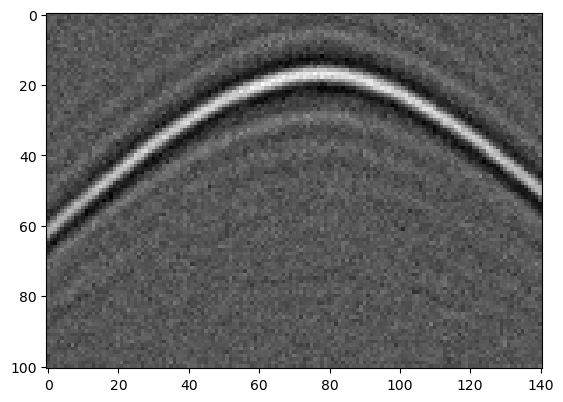

In [7]:
# Extract one sample from this dataset, and add Gaussian noise
idx_E1 = 0
input_E1 = test_data_E1[idx_E1] + nsr * torch.randn(test_data_E1[idx_E1].size())
plt.imshow(input_E1.T, cmap='gray')

In [8]:
# Predict over this one-event data sample
prob_E1, loc_E1 = test_one_data(network, input_E1.unsqueeze(dim=0).to(device))

In [9]:
# Evaluation - Detection Results
print(f'Detected number of event(s): {pred_event_number(prob_E1)}')

Detected number of event(s): 1


In [10]:
# Evaluation - Location Results
# true location(s)
with open('../data/testing_label_E1.bin', 'rb') as f:
    true_loc_tmp = np.fromfile(f, np.single)
true_loc_E1 = true_loc_tmp.reshape([ndata_E1, -1])[idx_E1, 0:2].reshape(-1,2)
print(f'True Source Location (m):\n{str_format(true_loc_E1)}')

# predicted location(s)
pred_loc_E1 = denorm_pred_loc(loc_E1.reshape(-1, 2))
print(f'\nPredicted Source Location (m):\n{str_format(pred_loc_E1)}')

# location error(s)
print(f'\nLocation Error (m):\n{str_format(calculate_loc_error(true_loc_E1, pred_loc_E1))}')

True Source Location (m):
[[2300. 1900.]]

Predicted Source Location (m):
[[2292.9 1920.4]]

Location Error (m):
[[21.6]]


### Case #2: Two-event Input Data (E2)

In [11]:
# Read two-event data
ndata_E2 = 1000
test_data_E2 = read_data("../data/testing_data_E2.bin", ndata_E2, nx, nt)
print(f'Data Size (ndata, nx, nt): {test_data_E2.shape}')

Data Size (ndata, nx, nt): torch.Size([1000, 141, 101])


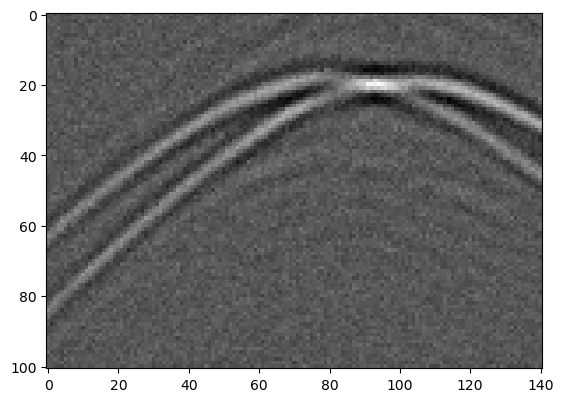

In [12]:
# Extract one sample from this dataset, and add Gaussian noise
idx_E2 = 3
input_E2 = test_data_E2[idx_E2] + nsr * torch.randn(test_data_E2[idx_E2].size())
plt.imshow(input_E2.T, cmap='gray')

In [13]:
# Predict over this two-event data sample
prob_E2, loc_E2 = test_one_data(network, input_E2.unsqueeze(dim=0).to(device))

In [14]:
# Evaluation - Detection Results
print(f'Detected number of event(s): {pred_event_number(prob_E2)}')

Detected number of event(s): 2


In [15]:
# Evaluation - Location Results
# true location(s)
with open('../data/testing_label_E2.bin', 'rb') as f:
    true_loc_tmp = np.fromfile(f, np.single)
true_loc_E2 = true_loc_tmp.reshape([ndata_E2, -1])[idx_E2].reshape(-1,2)
print(f'True Source Location (m):\n{str_format(true_loc_E2)}')

# predicted location(s)
pred_loc_E2 = denorm_pred_loc(loc_E2.reshape(-1, 2))
print(f'\nPredicted Source Location (m):\n{str_format(pred_loc_E2)}')

# location error(s)
print(f'\nLocation Error (m):\n{str_format(calculate_loc_error(true_loc_E2, pred_loc_E2))}')

True Source Location (m):
[[2420. 2160.]
 [3100. 2080.]]

Predicted Source Location (m):
[[2432.8 2172. ]
 [3088.4 2088.5]]

Location Error (m):
[[17.6]
 [14.3]]


### Case #3: Three-event Input Data (E3)

In [16]:
# Read three-event data
ndata_E3 = 1000
test_data_E3 = read_data("../data/testing_data_E3.bin", ndata_E3, nx, nt)
print(f'Data Size (ndata, nx, nt): {test_data_E3.shape}')

Data Size (ndata, nx, nt): torch.Size([1000, 141, 101])


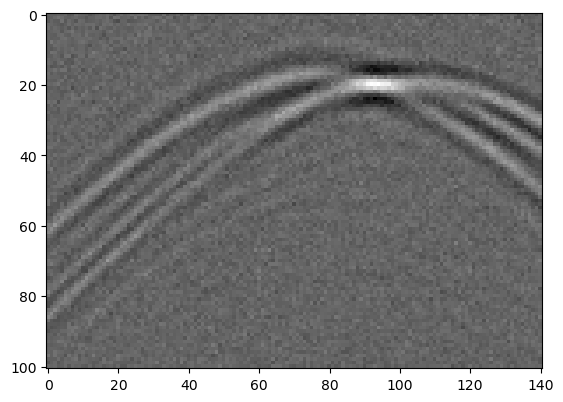

In [17]:
# Extract one sample from this dataset, and add Gaussian noise
idx_E3 = 6
input_E3 = test_data_E3[idx_E3] + nsr * torch.randn(test_data_E3[idx_E3].size())
plt.imshow(input_E3.T, cmap='gray')

In [18]:
# Predict over this three-event data sample
prob_E3, loc_E3 = test_one_data(network, input_E3.unsqueeze(dim=0).to(device))

In [19]:
# Evaluation - Detection Results
print(f'Detected number of event(s): {pred_event_number(prob_E3)}')

Detected number of event(s): 3


In [20]:
# Evaluation - Location Results
# true location(s)
with open('../data/testing_label_E3.bin', 'rb') as f:
    true_loc_tmp = np.fromfile(f, np.single)
true_loc_E3 = true_loc_tmp.reshape([ndata_E3, -1])[idx_E3].reshape(-1,2)
print(f'True Source Location (m):\n{str_format(true_loc_E3)}')

# predicted location(s)
pred_loc_E3 = denorm_pred_loc(loc_E3.reshape(-1, 2))
print(f'\nPredicted Source Location (m):\n{str_format(pred_loc_E3)}')

# location error(s)
print(f'\nLocation Error (m):\n{str_format(calculate_loc_error(true_loc_E3, pred_loc_E3))}')

True Source Location (m):
[[2840. 1940.]
 [2300. 1920.]
 [3140. 2060.]]

Predicted Source Location (m):
[[2846.9 1972. ]
 [2299.6 1945.3]
 [3139.6 2051.7]]

Location Error (m):
[[32.7]
 [25.3]
 [ 8.3]]
